## Notebook to calculate Sobol indices for performing model parameter sensitivity analysis

### Model: LGBM
### Property: Oxidative stability

**Created on 15th December, 2023; modified on 14th February, 2024**

In [1]:
%%bash
pwd
ls -ltr

/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/Science-rev-1/sensitivity-analysis/oxidative-stability
total 256
-rw-------@ 1 riteshk  staff  3960002 Feb 13 15:13 train_fgrp_feat.csv
-rw-------@ 1 riteshk  staff   495572 Feb 13 15:13 val_fgrp_feat.csv
-rw-------@ 1 riteshk  staff   497131 Feb 13 15:13 test_fgrp_feat.csv
-rw-------@ 1 riteshk  staff   714945 Feb 13 15:14 all_oxstab.csv
-rw-------@ 1 riteshk  staff   103162 Feb 14 11:37 sobol_analysis_cond_rand_lgbm_m3.ipynb
-rw-------@ 1 riteshk  staff   932994 Feb 14 12:20 lgbm_oxstab_rand_fold_1.sav
-rw-------@ 1 riteshk  staff   908767 Feb 14 12:20 lgbm_oxstab_rand_fold_2.sav
-rw-------@ 1 riteshk  staff   932000 Feb 14 12:20 lgbm_oxstab_rand_fold_3.sav
-rw-------@ 1 riteshk  staff   923899 Feb 14 12:20 lgbm_oxstab_rand_fold_4.sav
-rw-------@ 1 riteshk  staff   925086 Feb 14 12:20 lgbm_oxstab_rand_fold_5.sav
-rw-------@ 1 riteshk  staff     3435 Feb 14 13:55 sobol_analysis_lgbm_oxstab_rand.csv
-rw-

In [2]:
import numpy as np
# from keras.models import load_model
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
from SALib.sample import saltelli
from SALib.analyze import sobol
import pandas as pd
import os, sys
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors, Draw, PandasTools
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import dask
import dask.array
from dask import delayed
from dask.distributed import Client
import lightgbm
lightgbm.__version__

'4.1.0'

In [4]:
# path = '/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/Science-rev-1/coulombic-efficiency_1.1/using-pretrainedGR/gr-embed-200/common-log-output/stratified-split-2-cv/' ## on MacBook Pro

In [4]:
val_df = pd.read_csv('val_fgrp_feat.csv')
# train_df = pd.read_csv(path + 'strat_rs30_train_gr_comb_add.csv')
train_df = pd.read_csv('train_fgrp_feat.csv')
test_df = pd.read_csv('test_fgrp_feat.csv')
train_df

,smiles,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,fr_func_grp_9_solv,...,clogp,molar_refractivity,tpsa,frac_sp3,hall_kier_alpha,labute_ASA,num_valence_electron,max_partial_charge,min_partial_charge,IE
0,COCCOc1cscc1OC,0,0,0,0,0,0,0,0,0,...,1.78190,48.2420,27.69,0.500000,-0.74,75.872171,68,0.171467,-0.491993,4.306098
1,c1c(c2c(cc1)nccn2)C(=O)O,0,0,0,0,0,0,0,0,0,...,1.32800,46.4973,63.08,0.000000,-1.97,73.873062,64,0.337476,-0.477581,5.330098
2,C=Cc1cccc2c1[nH]sn2OCCOC,0,0,0,0,0,0,0,0,0,...,2.70270,68.0537,33.73,0.272727,-1.17,99.445369,86,0.103226,-0.382191,3.957699
3,c1ccc(cc1)C1(CCCC1)O,0,0,0,0,0,0,0,0,0,...,2.44820,48.8068,20.23,0.454545,-0.82,73.044516,64,0.089612,-0.385172,5.178552
4,C(#N)C1=COC(=CO1)N,0,0,0,0,0,0,0,0,0,...,0.15578,28.1364,68.27,0.000000,-1.63,51.773543,46,0.237928,-0.445084,3.910692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14500,CC(C)(C)c1cc(C#N)c2c(c1)ONO2,0,0,0,0,0,0,0,0,0,...,2.04658,54.2487,54.28,0.363636,-1.73,88.327892,78,0.213150,-0.369549,4.638594
14501,C=Cc1cscc1F,0,0,0,0,0,0,0,0,0,...,2.53020,34.3680,0.00,0.000000,-0.63,51.277583,42,0.140567,-0.205425,4.756748
14502,n1c(cncc1C)C,0,0,0,0,0,0,0,0,0,...,1.09344,31.5060,25.78,0.333333,-0.92,48.600583,42,0.055846,-0.260951,5.327466
14503,c1ccc(cc1)[C@@H]1[C@H](C(=O)O)SCCS1,2,0,0,0,0,0,0,0,0,...,2.66090,65.5228,37.30,0.363636,-0.61,97.452258,80,0.317615,-0.480376,4.915535


In [5]:
df_all = pd.concat([train_df, val_df, test_df], axis=0, ignore_index=True)
df_all.reset_index(drop=True, inplace=True)

In [8]:
zero_columns = list(df_all.columns[(df_all == 0).all()]) ## oxstab dataset has columns with only zero entries so have to remove them, otherwise causes problem with Sobol analysis
df_all.drop(columns=zero_columns, inplace=True)
train_df.drop(columns=zero_columns, inplace=True)
val_df.drop(columns=zero_columns, inplace=True)
test_df.drop(columns=zero_columns, inplace=True)
df_all.reset_index(drop=True, inplace=True)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_df.shape

(14505, 49)

In [ ]:
# df_all['min_partial_charge'].hasnans
# df_all.columns[(type(df_all) = float).all()]

In [9]:
## last two features have nans, so removing these entries as it causes problems with Sobol analysis
nan_min_partial_charge = list(np.where(np.isnan(df_all['min_partial_charge']))[0])
nan_max_partial_charge = list(np.where(np.isnan(df_all['max_partial_charge']))[0])
all_nans_ind = list(set(nan_min_partial_charge + nan_max_partial_charge))
all_nans_ind

[2113, 5705, 4010, 3503, 16883, 436, 9781, 17140, 1687, 13464, 1145, 15227]

In [10]:
df_all.drop(index=all_nans_ind, inplace=True)
df_all.reset_index(inplace=True, drop=True)
df_all

,smiles,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,fr_func_grp_9_solv,fr_func_grp_10_solv,...,clogp,molar_refractivity,tpsa,frac_sp3,hall_kier_alpha,labute_ASA,num_valence_electron,max_partial_charge,min_partial_charge,IE
0,COCCOc1cscc1OC,0,0,0,0,0,0,0,0,3,...,1.78190,48.2420,27.69,0.500000,-0.74,75.872171,68,0.171467,-0.491993,4.306098
1,c1c(c2c(cc1)nccn2)C(=O)O,0,0,0,0,0,0,0,0,0,...,1.32800,46.4973,63.08,0.000000,-1.97,73.873062,64,0.337476,-0.477581,5.330098
2,C=Cc1cccc2c1[nH]sn2OCCOC,0,0,0,0,0,0,0,0,1,...,2.70270,68.0537,33.73,0.272727,-1.17,99.445369,86,0.103226,-0.382191,3.957699
3,c1ccc(cc1)C1(CCCC1)O,0,0,0,0,0,0,0,0,1,...,2.44820,48.8068,20.23,0.454545,-0.82,73.044516,64,0.089612,-0.385172,5.178552
4,C(#N)C1=COC(=CO1)N,0,0,0,0,0,0,0,0,0,...,0.15578,28.1364,68.27,0.000000,-1.63,51.773543,46,0.237928,-0.445084,3.910692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18116,C(O)c1ccc(cc1)Cl,0,0,0,0,1,0,0,0,1,...,1.83230,37.3748,20.23,0.142857,-0.53,58.893845,48,0.068139,-0.391680,5.163176
18117,CCC1=COC=C(C#N)O1,0,0,0,0,0,0,0,0,0,...,1.64958,34.2400,42.25,0.285714,-1.43,59.163537,52,0.238068,-0.464407,4.477547
18118,C1CO[C@](C#N)(CO1)O,0,0,0,0,0,0,0,0,1,...,-0.75462,27.3338,62.48,0.800000,-0.63,52.607092,50,0.280664,-0.372224,6.066940
18119,CC(C)(C)c1ccc2c(c1)[nH]sn2N(=O)=O,0,0,0,0,0,0,0,0,0,...,2.97090,65.8291,58.41,0.400000,-1.43,98.212013,86,0.177580,-0.305088,4.017905


In [11]:
X_train = train_df.iloc[:,1:-1]
y_train = train_df.iloc[:,-1]

X_test = test_df.iloc[:,1:-1]
y_test = test_df.iloc[:,-1]

X_val = val_df.iloc[:,1:-1]
y_val = val_df.iloc[:,-1]

X_all = df_all.iloc[:,1:-1]
y_all = df_all.iloc[:,-1]

## scaling the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_ = np.array(X_train_scaled)
X_val_scaled = scaler.transform(X_val)
X_val_ = np.array(X_val_scaled)
X_test_scaled = scaler.transform(X_test)
X_test_ = np.array(X_test_scaled)
X_all_scaled = scaler.transform(X_all)
X_all_ = np.array(X_all_scaled)

In [12]:
X_train_.shape
# X_train.columns.to_list()
# list(np.where(np.isnan(X_all_[:,-1]))[0])

(14505, 47)

In [13]:
lgbm_models = []
for i in range(1,6):
#     filename = path + f'lgbm_oxstab_rand_fold_{i}.sav'
    filename = f'lgbm_oxstab_rand_fold_{i}.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    lgbm_models.append(loaded_model)

In [14]:
## generate a list of max and min of each feature in the form [[min1, max1], [min2, max2], ...]
min_max = []
for i in range(X_all_.shape[1]):
    min_max.append([X_all_[:,i].min(), X_all_[:,i].max()])
min_max

[[-0.19571950518255962, 11.699160757413923],
 [-0.09183971666022803, 32.59859194362462],
 [-0.22577429719696968, 11.933345186127454],
 [-0.00830340276741566, 120.43255373859675],
 [-0.26209183418617976, 16.0714937936142],
 [-0.026638661462201833, 64.37232542341073],
 [-0.018569533817705187, 53.85164807134504],
 [-0.24324497254327018, 11.083459126140948],
 [-0.4802742279660521, 7.187725416114946],
 [-0.027880951406153473, 62.18953445571017],
 [-0.11432758103163317, 15.311919515376173],
 [-0.011743189640401287, 170.3232225443803],
 [-0.24928419822970108, 14.646152651705682],
 [-0.02253707581514188, 72.62197063499218],
 [-0.018569533817705184, 53.85164807134503],
 [-0.008303402767415662, 120.43255373859678],
 [-0.024917081031941086, 40.13311184877978],
 [-0.024917081031941082, 40.13311184877977],
 [-0.008303402767415658, 120.43255373859672],
 [-0.018569533817705184, 53.85164807134503],
 [-0.026638661462201837, 64.37232542341073],
 [-0.027548770056267147, 36.299261199594184],
 [-0.00830340

In [15]:
# Define the problem for sensitivity analysis
problem = {
    'num_vars': lgbm_models[0].n_features_in_,  # Number of features in the model
    'names': X_train.columns.to_list(),  # Feature names
    'bounds': min_max  # feature range
}

**Average of all five models**

In [16]:
first_order_sobol = []
total_order_sobol = []

# Create a Dask client with 4 workers
client = Client(n_workers=16)

# Generate samples
param_values = saltelli.sample(problem, 2**10)
print('sample generation done...')

count = 0
for model in lgbm_models:
    # Evaluate the model for each sample
    predictions = []
    for params in param_values:
        prediction = model.predict(np.array([params]))
        if np.isscalar(prediction):
            predictions.append(prediction)
        else:
            predictions.append(prediction[0])

    predictions = np.array(predictions)

    # Perform Sobol analysis
    sobol_analysis = sobol.analyze(problem, predictions.ravel())
    print('Sobol analsis done for model: ', count)
    count += 1

    # Store the first-order and total-order Sobol indices
    first_order_sobol.append(sobol_analysis['S1'])
    total_order_sobol.append(sobol_analysis['ST'])

# Convert the lists to NumPy arrays
first_order_sobol = np.array(first_order_sobol)
total_order_sobol = np.array(total_order_sobol)

# Compute the average and standard deviation
avg_first_order_sobol = np.mean(first_order_sobol, axis=0)
std_first_order_sobol = np.std(first_order_sobol, axis=0)
avg_total_order_sobol = np.mean(total_order_sobol, axis=0)
std_total_order_sobol = np.std(total_order_sobol, axis=0)

# Create a DataFrame with the results
df_sobol = pd.DataFrame({
    'feature': problem['names'],
    'avg_first_order': avg_first_order_sobol,
    'std_first_order': std_first_order_sobol,
    'avg_total_order': avg_total_order_sobol,
    'std_total_order': std_total_order_sobol,
})

# Set the feature names as the index
df_sobol.set_index('feature', inplace=True)

df_sobol

/scratch/local/jobs/16319216/ipykernel_1874827/1033189214.py:8: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 2**10)


sample generation done...
Sobol analsis done for model:  0
Sobol analsis done for model:  1
Sobol analsis done for model:  2
Sobol analsis done for model:  3
Sobol analsis done for model:  4


,avg_first_order,std_first_order,avg_total_order,std_total_order
feature,,,,
fr_func_grp_1_solv,0.000399,0.000716,0.000455,0.000131
fr_func_grp_2_solv,-0.000104,0.000052,0.000025,0.000013
fr_func_grp_3_solv,0.001012,0.001290,0.001620,0.000841
fr_func_grp_4_solv,0.000000,0.000000,0.000000,0.000000
fr_func_grp_5_solv,0.001068,0.001076,0.001527,0.001203
fr_func_grp_7_solv,0.000000,0.000000,0.000000,0.000000
fr_func_grp_8_solv,0.000000,0.000000,0.000000,0.000000
fr_func_grp_9_solv,0.024724,0.007922,0.040802,0.009105
fr_func_grp_10_solv,0.005458,0.005940,0.013917,0.004027


In [17]:
param_values

array([[-1.78295364e-01,  1.22149585e+01,  5.21851895e+00, ...,
         4.64018070e+00, -4.22876096e+00, -7.77158693e-01],
       [ 3.07943279e-02,  1.22149585e+01,  5.21851895e+00, ...,
         4.64018070e+00, -4.22876096e+00, -7.77158693e-01],
       [-1.78295364e-01,  3.22633873e+01,  5.21851895e+00, ...,
         4.64018070e+00, -4.22876096e+00, -7.77158693e-01],
       ...,
       [ 9.07973156e+00,  5.35124485e+00,  8.95887309e+00, ...,
         8.47583506e+00, -1.54747441e+00,  1.94727305e+00],
       [ 9.07973156e+00,  5.35124485e+00,  8.95887309e+00, ...,
         8.47583506e+00,  1.72711809e+00,  2.54764866e+00],
       [ 9.07973156e+00,  5.35124485e+00,  8.95887309e+00, ...,
         8.47583506e+00,  1.72711809e+00,  1.94727305e+00]])

In [18]:
df_sobol.to_csv('sobol_analysis_lgbm_oxstab_rand.csv')

In [3]:
## plotting on local computer (MacBook Pro)
orange = (0.984, 0.713, 0.305) # 251, 182, 78 
anvil = (0.298, 0.78, 0.77) # 76, 199, 196

In [4]:
df_sobol = pd.read_csv('sobol_analysis_lgbm_oxstab_rand.csv')
df_sobol

,feature,avg_first_order,std_first_order,avg_total_order,std_total_order
0,fr_func_grp_1_solv,0.000399,0.000716,0.000455,0.000131
1,fr_func_grp_2_solv,-0.000104,0.000052,0.000025,0.000013
2,fr_func_grp_3_solv,0.001012,0.001290,0.001620,0.000841
3,fr_func_grp_4_solv,0.000000,0.000000,0.000000,0.000000
4,fr_func_grp_5_solv,0.001068,0.001076,0.001527,0.001203
5,fr_func_grp_7_solv,0.000000,0.000000,0.000000,0.000000
6,fr_func_grp_8_solv,0.000000,0.000000,0.000000,0.000000
7,fr_func_grp_9_solv,0.024724,0.007922,0.040802,0.009105
8,fr_func_grp_10_solv,0.005458,0.005940,0.013917,0.004027
9,fr_func_grp_11_solv,0.000000,0.000000,0.000000,0.000000


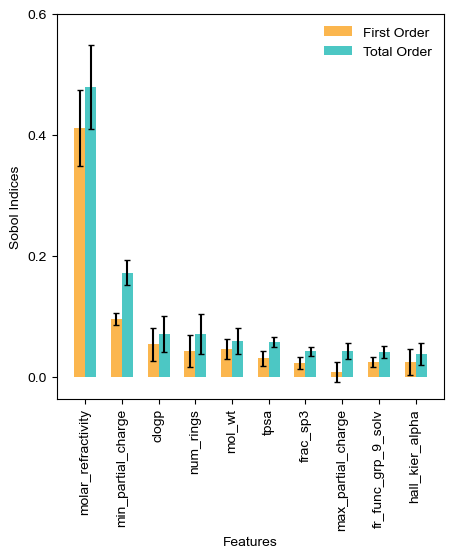

In [6]:
# Plotting Sobol indices for top 10 features having highest total order indices
df_sobol_ = df_sobol.sort_values(by='avg_total_order', ascending=False).iloc[:10,:]
features = df_sobol_['feature']
avg_first_order = df_sobol_['avg_first_order']
std_first_order = df_sobol_['std_first_order']
avg_total_order = df_sobol_['avg_total_order']
std_total_order = df_sobol_['std_total_order']

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(5, 5))

# Set the bar width
bar_width = 0.3

# Set the opacity
opacity = 1.0

# Plot the first order Sobol indices
rects1 = ax.bar(np.arange(len(features)) - bar_width/2, avg_first_order, bar_width, alpha=opacity, color=orange, yerr=std_first_order, label='First Order', capsize=2)

# Plot the total order Sobol indices
rects2 = ax.bar(np.arange(len(features)) + bar_width/2, avg_total_order, bar_width, alpha=opacity, color=anvil, yerr=std_total_order, label='Total Order', capsize=2)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Features')
ax.set_ylabel('Sobol Indices')
# ax.set_title('Sobol Indices by Feature')
ax.set_yticks([0.0, 0.2, 0.4, 0.6])
ax.set_yticklabels([0.0, 0.2, 0.4, 0.6])
ax.set_xticks(np.arange(len(features)))
ax.set_xticklabels(features, rotation=90)
ax.legend(frameon=False)

# Show the plot
# plt.show()
plt.savefig('plot_sobol_analysis_lgbm_oxstab_rand.eps', dpi=300)

<AxesSubplot:xlabel='feature'>

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


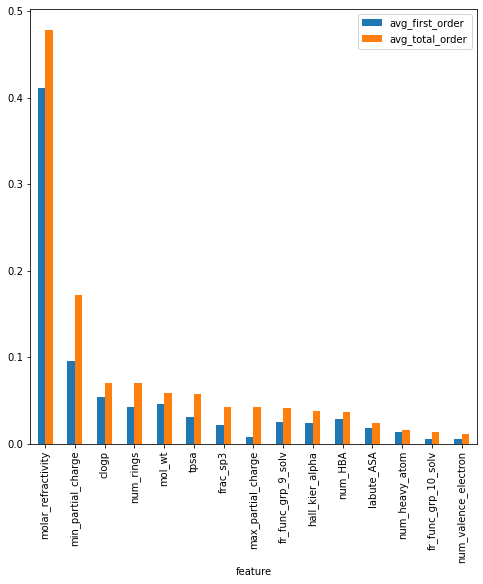

In [19]:
# df_ = df_sobol.sort_values(by='avg_total_order', ascending=False).iloc[:15,:]
# df_[['avg_first_order', 'avg_total_order']].plot.bar(yerr=df_[['std_first_order', 'std_total_order']], rot=90, figsize=(8,8))